In [3]:
### 0.0 loading package 
import numpy as np
import pandas as pd
#import modin.pandas as modin_pd
import matplotlib.pyplot as plt 
from matplotlib import pylab
import seaborn as sns 
from sklearn.metrics.pairwise import cosine_similarity
from statannot import add_stat_annotation
import matplotlib as mpl
from scipy import stats, cluster
import glob
import re
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats import multitest
from scipy.stats.mstats import winsorize
#import numpy_ext as npext
#from adjustText import adjust_text
#from numpy_ext import rolling_apply
#from venn import venn

#from scipy.stats import hypergeom
#from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.multitest import multipletests

#import pybedtools

import os
## path = "C:\\temp\myFolder\example\\"
## newPath = path.replace(os.sep, '/')
def change_slash_in_path(path):
    newpath = path.replace(os.sep, '/')
    return newpath

from adjustText import adjust_text

import warnings
warnings.simplefilter('ignore')

## load_large_dataFrame
def load_large_dataFrame(input_file, sep=",", header=0, index_col=0, chunksize=100000, compressed=False):
    if compressed:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col, compression='gzip')
    else:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col)
    dfList=[]
    for df in TextFileReader:
        dfList.append(df)
    final_df = pd.concat(dfList,sort=False)
    return final_df

In [5]:
#from multiprocesspandas import applyparallel
from joblib import Parallel, delayed
import time
from pandarallel import pandarallel

# Reactivity vs Rsquare

## 1. Generate mutrate/coverage/mutant matrix

### 1.1. loading sample list

In [6]:
sample_lst = load_large_dataFrame("../../../Data/RiboSwitch/MUX11957.sample_list.txt", sep="\t")
sample_lst = sample_lst.reset_index()
sample_lst.index = sample_lst['sample_id']
sample_lst

,sample_id,transfer,treatment,ref,cell_id
sample_id,,,,,
RHX644,RHX644,in_vivo,DMSO,WT,W1
RHX645,RHX645,in_vivo,NAI_N3,WT,W1
RHX646,RHX646,in_vivo,NAI_N3,WT,W9
RHX647,RHX647,in_vivo,NAI_N3,WT,W17
RHX651,RHX651,in_vivo,DMSO,WT,W2
...,...,...,...,...,...
RHX751,RHX751,in_vitro,NAI_N3,MT,M16
RHX706,RHX706,18s,DMSO,WT,R1
RHX713,RHX713,18s,DMSO,WT,R2


### 1.2 loading mutrate/coverage/mutant matrix

In [7]:
dirs = glob.glob("../../../Data/RiboSwitch/mutrate_matrix/R*")
concat_mutant = []
concat_mutrate = []
concat_coverage = []

for dir in dirs:
    dir = change_slash_in_path(dir)
    sample_id = dir.split("/")[-1].split("_")[0]
    #print (sample_id)
    brc_output = load_large_dataFrame("{}/{}.mutrate.txt.gz".format(dir,sample_id), sep="\t", header=None, index_col=None)
    col_names = ["gene","pos","end","id","mutrate","strand","coverage","mutant","normalized_cov","gene_expr","ntref","detail"]
    brc_output.columns = col_names
    brc_output = brc_output.set_index(['gene', 'pos'])
    mutrate_df = brc_output[['mutrate']]
    coverage_df = brc_output[['coverage']]
    mutant_df = brc_output[['mutant']]
    mutrate_df.columns = [sample_id]
    mutant_df.columns = [sample_id]
    coverage_df.columns = [sample_id]
    
    concat_mutant.append(mutant_df)
    concat_mutrate.append(mutrate_df)    
    concat_coverage.append(coverage_df)
    
mutant_df = pd.concat(concat_mutant, axis=1)
mutrate_df = pd.concat(concat_mutrate, axis=1)
coverage_df = pd.concat(concat_coverage, axis=1)

### add columns

mutrate_df = mutrate_df.loc[:, sample_lst.index]
mutrate_df.columns = pd.MultiIndex.from_frame(sample_lst)
mutrate_df

mutant_df = mutant_df.loc[:, sample_lst.index]
mutant_df.columns = pd.MultiIndex.from_frame(sample_lst)
mutant_df

coverage_df = coverage_df.loc[:, sample_lst.index]
coverage_df.columns = pd.MultiIndex.from_frame(sample_lst)
coverage_df

sample_id           RHX644  RHX645  RHX646  RHX647  RHX651  RHX652  RHX653  \
transfer           in_vivo in_vivo in_vivo in_vivo in_vivo in_vivo in_vivo   
treatment             DMSO  NAI_N3  NAI_N3  NAI_N3    DMSO  NAI_N3  NAI_N3   
ref                     WT      WT      WT      WT      WT      WT      WT   
cell_id                 W1      W1      W9     W17      W2      W2     W10   
gene           pos                                                           
Tetrahymena_WT 1    3000.0  2179.0  1595.0  1756.0  4294.0  2297.0  2344.0   
               2    3934.0  2709.0  2026.0  2176.0  5692.0  2887.0  2878.0   
               3    5346.0  3524.0  2765.0  2723.0  7840.0  3729.0  3616.0   
               4    5817.0  3783.0  2942.0  2893.0  8513.0  4034.0  3843.0   
               5    6626.0  4281.0  3349.0  3272.0  9750.0  4648.0  4323.0   
...                    ...     ...     ...     ...     ...     ...     ...   
human_large    771     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
               772     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
               773     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
               774     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
               745     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

sample_id           RHX654  RHX658  RHX659  ...   RHX744   RHX745   RHX746  \
transfer           in_vivo in_vivo in_vivo  ... in_vitro in_vitro in_vitro   
treatment           NAI_N3    DMSO  NAI_N3  ...   NAI_N3   NAI_N3     DMSO   
ref                     WT      WT      WT  ...       MT       MT       MT   
cell_id                W18      W3      W3  ...       M7      M15       M4   
gene           pos                          ...                              
Tetrahymena_WT 1    1087.0  2963.0  2395.0  ...      NaN      NaN      NaN   
               2    1294.0  3824.0  3078.0  ...      NaN      NaN      NaN   
               3    1577.0  5164.0  4172.0  ...      NaN      NaN      NaN   
               4    1670.0  5604.0  4555.0  ...      NaN      NaN      NaN   
               5    1865.0  6365.0  5193.0  ...      NaN      NaN      NaN   
...                    ...     ...     ...  ...      ...      ...      ...   
human_large    771     NaN     NaN     NaN  ...      NaN      NaN      NaN   
               772     NaN     NaN     NaN  ...      NaN      NaN      NaN   
               773     NaN     NaN     NaN  ...      NaN      NaN      NaN   
               774     NaN     NaN     NaN  ...      NaN      NaN      NaN   
               745     NaN     NaN     NaN  ...      NaN      NaN      NaN   

sample_id            RHX749   RHX750   RHX751 RHX706 RHX713 RHX720 RHX727  
transfer           in_vitro in_vitro in_vitro    18s    18s    18s    18s  
treatment            NAI_N3   NAI_N3   NAI_N3   DMSO   DMSO NAI_N3 NAI_N3  
ref                      MT       MT       MT     WT     WT     WT     WT  
cell_id                 M20       M8      M16     R1     R2     R1     R2  
gene           pos                                                         
Tetrahymena_WT 1        NaN      NaN      NaN    NaN    3.0    1.0    1.0  
               2        NaN      NaN      NaN    NaN    4.0    2.0    1.0  
               3        NaN      NaN      NaN    NaN    4.0    2.0    2.0  
               4        NaN      NaN      NaN    NaN    4.0    2.0    2.0  
               5        NaN      NaN      NaN    NaN    4.0    2.0    2.0  
...                     ...      ...      ...    ...    ...    ...    ...  
human_large    771      NaN      NaN      NaN    NaN    NaN    NaN    NaN  
               772      NaN      NaN      NaN    NaN    NaN    NaN    NaN  
               773      NaN      NaN      NaN    NaN    NaN    NaN    NaN  
               774      NaN      NaN      NaN    NaN    NaN    NaN    NaN  
               745      NaN      NaN      NaN    NaN    NaN    NaN    NaN  

[12370 rows x 108 columns]

### 1.3 generate reactivity for each condition

In [6]:
avg_coverage = coverage_df.groupby(level=['transfer', 'treatment', 'ref'], axis=1).mean().sort_index()

coverage_threshold = 1000
concat_categories_lst = []
for (transfer,ref), subset in mutrate_df.groupby(level=['transfer','ref'], axis=1):
    #print (transfer, ref)
    local_coverage_df = avg_coverage.loc[avg_coverage.loc[:, (avg_coverage.columns.get_level_values('transfer')==transfer)&(avg_coverage.columns.get_level_values('ref')==ref)].min(axis=1) > coverage_threshold]
    
    dmso_df = subset.xs('DMSO', level="treatment", axis=1, drop_level=False)
    nain3_df = subset.xs('NAI_N3', level="treatment", axis=1, drop_level=False)
    nain3_df = nain3_df.sort_index()

    temp_dmso_df = pd.concat([dmso_df.mean(axis=1)]*nain3_df.columns.size, axis=1)
    temp_dmso_df.columns = nain3_df.columns
    temp_dmso_df = temp_dmso_df.loc[nain3_df.index]

    reac_df = nain3_df - temp_dmso_df
    reac_df = reac_df.loc[reac_df.index.isin(local_coverage_df.index)]
    reac_df
    
    ## change ref labels on gene
    concat_lst = []
    for gene, gene_subset in reac_df.groupby(level='gene'):
        if "WT" in gene:
            gene = gene.split("_")[0]
        elif "MT" in gene:
            gene = gene.split("_")[0]
        #print ("#"+gene+"#")
        idx_df = gene_subset.index.to_frame()
        idx_df.index = list(range(idx_df.index.size))
        idx_df['gene'] = gene
        idx_df['gene'] = idx_df['gene'].astype(str)
        idx_df['pos'] = idx_df['pos'].astype(np.int64)
        
        gene_subset.index = pd.MultiIndex.from_frame(idx_df)
        concat_lst.append(gene_subset)
    reac_df = pd.concat(concat_lst)
    concat_categories_lst.append(reac_df)
reac_df = pd.concat(concat_categories_lst, axis=1)
reac_df = reac_df.sort_index()
reac_df

sample_id    RHX720 RHX727    RHX704    RHX705    RHX711    RHX712    RHX718  \
transfer        18s    18s  in_vitro  in_vitro  in_vitro  in_vitro  in_vitro   
treatment    NAI_N3 NAI_N3    NAI_N3    NAI_N3    NAI_N3    NAI_N3    NAI_N3   
ref              WT     WT        MT        MT        MT        MT        MT   
cell_id          R1     R2        M1        M9        M2       M10        M3   
gene     pos                                                                   
Den1     1      NaN    NaN -0.037864 -0.056180 -0.068342 -0.103428 -0.034311   
         2      NaN    NaN -0.060269 -0.088567 -0.086984 -0.123338 -0.055240   
         3      NaN    NaN -0.005395 -0.031260 -0.012724 -0.053158  0.001523   
         4      NaN    NaN -0.010114 -0.012350  0.002716 -0.006607 -0.000837   
         5      NaN    NaN  0.035343  0.034732  0.020698  0.030428  0.034171   
...             ...    ...       ...       ...       ...       ...       ...   
ypaA_FMN 348    NaN    NaN  0.023772 -0.004336  0.025160  0.017368  0.038151   
         349    NaN    NaN  0.002174  0.007090 -0.003921 -0.000998 -0.004192   
         350    NaN    NaN  0.075066  0.016610  0.089057  0.031386  0.122230   
         351    NaN    NaN -0.003801 -0.009152  0.006012 -0.006546  0.003061   
         352    NaN    NaN -0.003158 -0.006723  0.000281 -0.004813  0.002327   

sample_id       RHX719    RHX725    RHX726  ...    RHX675    RHX680    RHX681  \
transfer      in_vitro  in_vitro  in_vitro  ...   in_vivo   in_vivo   in_vivo   
treatment       NAI_N3    NAI_N3    NAI_N3  ...    NAI_N3    NAI_N3    NAI_N3   
ref                 MT        MT        MT  ...        WT        WT        WT   
cell_id            M11        M4       M12  ...       W21        W6       W14   
gene     pos                                ...                                 
Den1     1   -0.072488  0.016749 -0.066407  ... -0.193869 -0.168942 -0.173057   
         2   -0.093356  0.005044 -0.090691  ... -0.062333 -0.056682 -0.063918   
         3   -0.048684  0.030856 -0.040692  ... -0.016283 -0.002033 -0.009850   
         4   -0.003349 -0.020717 -0.021741  ...  0.015094  0.016529  0.017882   
         5    0.022478  0.029093  0.023118  ...  0.082173  0.082564  0.064888   
...                ...       ...       ...  ...       ...       ...       ...   
ypaA_FMN 348  0.020453  0.040112  0.019689  ... -0.009026 -0.015788 -0.017730   
         349  0.003549 -0.000822  0.003346  ...  0.010589  0.004716 -0.001630   
         350  0.023255  0.125221  0.046485  ... -0.102872 -0.086869 -0.064663   
         351 -0.007952  0.001364 -0.006716  ... -0.020547 -0.032125 -0.014189   
         352 -0.015246  0.001284 -0.002186  ...       NaN       NaN       NaN   

sample_id       RHX682    RHX687    RHX688    RHX689    RHX694    RHX695  \
transfer       in_vivo   in_vivo   in_vivo   in_vivo   in_vivo   in_vivo   
treatment       NAI_N3    NAI_N3    NAI_N3    NAI_N3    NAI_N3    NAI_N3   
ref                 WT        WT        WT        WT        WT        WT   
cell_id            W22        W7       W15       W23        W8       W16   
gene     pos                                                               
Den1     1   -0.151384 -0.173590 -0.213617 -0.156153 -0.173694 -0.235244   
         2   -0.043907 -0.062126 -0.060507 -0.055092 -0.050170 -0.068527   
         3    0.006125  0.005422  0.002205  0.003638  0.017367  0.009259   
         4    0.025384  0.027015  0.036447  0.018907  0.038364  0.053915   
         5    0.077796  0.069708  0.094430  0.061369  0.077227  0.101986   
...                ...       ...       ...       ...       ...       ...   
ypaA_FMN 348  0.002353 -0.004690 -0.004015  0.005795  0.022653  0.020402   
         349  0.007083  0.003912  0.012059  0.008151 -0.000145  0.002692   
         350 -0.030104 -0.045579 -0.034558 -0.053431  0.011304  0.008581   
         351 -0.013964 -0.016938 -0.014886 -0.026900 -0.013649 -0.024358   
         352       NaN       NaN       NaN   

### 1.4 heterogeneity of riboswitches/ribosnitches by Rsquare

In [8]:
def merge_wt_mt_ref(mutant_df):
    concat_categories_lst = []
    for ref, subset in mutant_df.copy().groupby(level=['ref'], axis=1):
        #print (subset)
        ## change ref labels on gene
        concat_lst = []
        for gene, gene_subset in subset.groupby(level='gene'):
            if ref in gene:
                gene = gene.split("_")[0]
                idx_df = gene_subset.index.to_frame()
                idx_df.index = list(range(idx_df.index.size))
                idx_df['gene'] = gene
                idx_df['gene'] = idx_df['gene'].astype(str)
                idx_df['pos'] = idx_df['pos'].astype(np.int64)
                gene_subset.index = pd.MultiIndex.from_frame(idx_df)
                concat_lst.append(gene_subset)
            elif {"WT":'MT',"MT":'WT'}[ref] in gene:
                continue
            else:
                concat_lst.append(gene_subset)
        mutant_df = pd.concat(concat_lst)
        concat_categories_lst.append(mutant_df)
    out_mutant_df = pd.concat(concat_categories_lst, axis=1)
    out_mutant_df = out_mutant_df.sort_index()
    return out_mutant_df

In [9]:
riboswitch_reac = reac_df.loc[:, reac_df.columns.get_level_values('transfer').isin(['in_vitro','in_vivo'])]
riboswitch_reac

riboswitch_mutant = mutant_df.loc[:, riboswitch_reac.columns]
riboswitch_mutrate = mutrate_df.loc[:, riboswitch_reac.columns]
riboswitch_coverage = coverage_df.loc[:, riboswitch_reac.columns]

riboswitch_mutant = merge_wt_mt_ref(riboswitch_mutant)
riboswitch_mutrate = merge_wt_mt_ref(riboswitch_mutrate)
riboswitch_coverage = merge_wt_mt_ref(riboswitch_coverage)

#riboswitch_coverage
riboswitch_mutant = riboswitch_mutant.mask(riboswitch_coverage<2000, np.nan)
riboswitch_mutrate = riboswitch_mutrate.mask(riboswitch_coverage<2000, np.nan)
riboswitch_coverage = riboswitch_coverage.mask(riboswitch_coverage<2000, np.nan)

In [11]:
def calculate_Rsq_of_coverage_to_mutant(mutant_df, coverage_df):
    mutant_df = mutant_df.dropna(how="all")
    coverage_df = coverage_df.dropna(how="all")
    intersect_index = mutant_df.index.intersection(coverage_df.index)
    concat_list = []
    for idx in intersect_index:
        mutant_series = mutant_df.loc[idx]
        coverage_series = coverage_df.loc[idx]
        mutant_series = mutant_series.dropna()
        coverage_series = coverage_series.dropna()
        intersect_index = mutant_series.index.intersection(coverage_series.index)
        mutant_series = mutant_series.loc[intersect_index]
        coverage_series = coverage_series.loc[intersect_index]
        
        if (mutant_series.size <= 5) or (coverage_series.size <= 5):
            continue
        # print (mutant_series)
        # print (coverage_series)
        try:
            slope, intercept, r, p, stderr = stats.linregress(coverage_series, mutant_series)
        except:
            slope, intercept, r, p, stderr = np.nan, np.nan, np.nan, np.nan, np.nan
        out_series = pd.Series([slope, intercept, r, p, stderr], index=['slope','intercept','r','p','stderr'], name=idx)
        out_series['rsq'] = np.power(out_series['r'], 2)
        #print (out_series)
        #out_series.name = pd.MultiIndex.from_tuples(idx, names=['gene','pos'])
        concat_list.append(out_series)
    out = pd.concat(concat_list, axis=1)
    out = out.T
    out.index.names = ['gene', 'pos']
    return out

def heterogeneity_by_rsquare(mutant_df, coverage_df):
    dmso_mutant = mutant_df.loc[:, mutant_df.columns.get_level_values('treatment')=="DMSO"]
    nain3_mutant = mutant_df.loc[:, mutant_df.columns.get_level_values('treatment')=="NAI_N3"]
    dmso_coverage = coverage_df.loc[:, coverage_df.columns.get_level_values('treatment')=="DMSO"]
    nain3_coverage = coverage_df.loc[:, coverage_df.columns.get_level_values('treatment')=="NAI_N3"]
    
    #dmso_rsquare = calculate_Rsq_of_coverage_to_mutant(dmso_mutant, dmso_coverage)
    nai_rsquare = calculate_Rsq_of_coverage_to_mutant(nain3_mutant, nain3_coverage)
    #return dmso_rsquare, nai_rsquare
    return nai_rsquare 

In [204]:
structure_diff_regions = riboswitch_reac.groupby(level=['transfer','ref'], axis=1).mean()
structure_diff_regions = structure_diff_regions.xs('in_vivo', level="transfer", axis=1)
structure_diff_regions['diff_reac'] = structure_diff_regions['MT'] -  structure_diff_regions['WT']
structure_diff_regions = structure_diff_regions.dropna()
structure_diff_regions['diff_reac.zscore'] = stats.zscore(structure_diff_regions['diff_reac'])
#structure_diff_regions.loc['Tetrahymena']

structure_diff_regions = structure_diff_regions.loc[structure_diff_regions.index.get_level_values('gene').isin(['Tetrahymena','Den1','HIV'])]
structure_diff_regions = structure_diff_regions.loc[np.abs(structure_diff_regions['diff_reac.zscore'])>=1.96]


In [205]:
idx_df = structure_diff_regions.index.to_frame()
concat_lst = []
for _, row in idx_df.iterrows():
    gene=row['gene']
    pos=row['pos']
    #for n in range(-2,3):
    concat_lst.append([gene, pos])
temp = pd.DataFrame(concat_lst)
temp = temp.loc[temp[1]>0]
temp = temp.drop_duplicates()
temp.columns = ['gene','pos']
structure_diff_regions_index = pd.MultiIndex.from_frame(temp)

#### 1.4.1 Rsq by combining WT and MT

In [92]:
### calculate rsquare which population that combining WT and MT together
concat_lst = []
for transfer in ['in_vivo', 'in_vitro']:
    local_mutant = riboswitch_mutant.loc[:, riboswitch_mutant.columns.get_level_values('transfer')==transfer]
    local_coverage = riboswitch_coverage.loc[:,riboswitch_coverage.columns.get_level_values('transfer')==transfer] 
    ref_rsquare = heterogeneity_by_rsquare(local_mutant, local_coverage)
    ref_rsquare['transfer'] = transfer
    ref_rsquare['ref'] = "Mix"
    concat_lst.append(ref_rsquare)
rsquare_df = pd.concat(concat_lst)
rsquare_df

slope   intercept         r             p    stderr  \
gene     pos                                                           
Den1     1    0.516657   95.833597  0.959316  3.039458e-25  0.023188   
         2    0.145342  155.919242  0.887953  3.994367e-17  0.011100   
         3    0.145444  -58.209600  0.886456  5.330316e-17  0.011196   
         4    0.188413 -156.009690  0.964374  3.297463e-28  0.007621   
         5    0.129324 -140.066224  0.950164  6.375567e-25  0.006256   
...                ...         ...       ...           ...       ...   
ypaA_FMN 348  0.165091 -127.717236  0.982116  3.619902e-29  0.005134   
         349  0.030811   19.336019  0.976673  5.383042e-27  0.001099   
         350  0.689823 -336.071511  0.991672  1.943227e-35  0.014533   
         351  0.976635  -29.036802  0.999964  3.787199e-78  0.001371   
         352  0.984465  -17.222294  0.999946  5.576226e-67  0.001788   

                   rsq  transfer  ref  
gene     pos                           
Den1     1    0.920287   in_vivo  Mix  
         2    0.788460   in_vivo  Mix  
         3    0.785804   in_vivo  Mix  
         4    0.930016   in_vivo  Mix  
         5    0.902812   in_vivo  Mix  
...                ...       ...  ...  
ypaA_FMN 348  0.964553  in_vitro  Mix  
         349  0.953890  in_vitro  Mix  
         350  0.983412  in_vitro  Mix  
         351  0.999927  in_vitro  Mix  
         352  0.999891  in_vitro  Mix  

[16807 rows x 8 columns]

In [90]:
reac_in_wtmt_df = riboswitch_reac.groupby(level=['transfer'], axis=1).mean()
col_df = reac_in_wtmt_df.columns.to_frame()
col_df['feature'] = 'reac'
reac_in_wtmt_df.columns = pd.MultiIndex.from_frame(col_df)
#reac_in_wtmt_df

rsq_in_wtmt_df = rsquare_df.reset_index().pivot(index=['gene','pos'], columns=['transfer'], values='rsq')
col_df = rsq_in_wtmt_df.columns.to_frame()
col_df['feature'] = 'rsq'
rsq_in_wtmt_df.columns = pd.MultiIndex.from_frame(col_df)
#rsq_in_wtmt_df

reac2rsq_in_wtmt_df = pd.concat([reac_in_wtmt_df, rsq_in_wtmt_df], axis=1)
reac2rsq_in_wtmt_df

reac2rsq_in_wtmt_df_Mixed = reac2rsq_in_wtmt_df.copy()
reac2rsq_in_wtmt_df_Mixed

transfer          in_vitro   in_vivo  in_vitro   in_vivo
feature               reac      reac       rsq       rsq
gene        pos                                         
Den1        1    -0.059480 -0.181894  0.972018  0.920287
            2    -0.045394 -0.059664  0.839778  0.788460
            3     0.004213 -0.008360  0.898981  0.785804
            4    -0.003595  0.016299  0.959773  0.930016
            5     0.031598  0.075706  0.977359  0.902812
...                    ...       ...       ...       ...
human_large 5161       NaN       NaN  0.002800       NaN
            5162       NaN       NaN  0.280059       NaN
            5163       NaN       NaN  0.240785       NaN
            5164       NaN       NaN  0.294378       NaN
            5165       NaN       NaN  0.005657       NaN

[8507 rows x 4 columns]

rvalue -0.1897030503244863


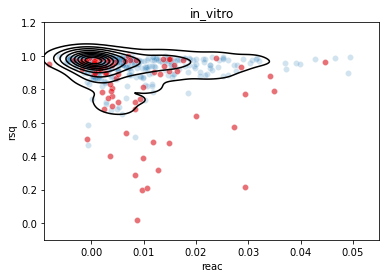

rvalue -0.04378197090169337


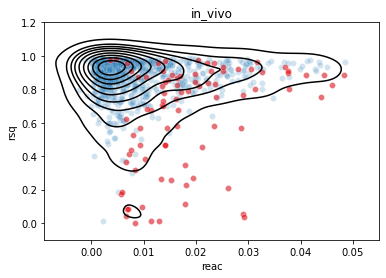

In [214]:
for transfer, subset in reac2rsq_in_wtmt_df_Mixed.groupby(level=['transfer'], axis=1):
    subset.columns = subset.columns.get_level_values('feature')
    riboswitch_subset = subset.loc[subset.index.get_level_values('gene').isin(['Tetrahymena','Den1','HIV'])]
    riboswitch_subset = riboswitch_subset.loc[riboswitch_subset['reac']>-0.02]
    riboswitch_subset = riboswitch_subset.loc[riboswitch_subset['reac']<0.05]
    riboswitch_subset = riboswitch_subset.loc[riboswitch_subset.index.get_level_values('pos')>=30]
    riboswitch_subset = riboswitch_subset.dropna()
    #print (riboswitch_subset)
    
    fig, ax = plt.subplots(1,1)
    sns.scatterplot(data=riboswitch_subset, x="reac", y="rsq", alpha=0.2, ax=ax)
    sns.kdeplot(data=riboswitch_subset, x="reac", y="rsq", color="black", ax=ax)
    
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(riboswitch_subset['reac'], riboswitch_subset['rsq'])
    #print (slope, intercept, rvalue, pvalue, stderr)
    print ("rvalue", rvalue)
    
    
    #sigdiff_subset = riboswitch_subset.loc[riboswitch_subset.index.isin(structure_diff_regions.index)]
    sigdiff_subset = riboswitch_subset.loc[riboswitch_subset.index.isin(structure_diff_regions_index)]
    sns.scatterplot(data=sigdiff_subset, x="reac", y="rsq", alpha=0.5, color="red", ax=ax)
    
    ax.set_xlim(-0.009, 0.055)
    ax.set_ylim(-0.1, 1.2)
    
    plt.title("{}".format(transfer))
    #plt.savefig("reac2rsq_in_Riboswitches/reac2rsq.Mixed.{}.pdf".format(transfer))
    plt.show()

#### 1.4.2 Rsq by separated WT and MT

In [93]:
concat_lst = []
for transfer in ['in_vivo', 'in_vitro']:
    local_mutant = riboswitch_mutant.loc[:, riboswitch_mutant.columns.get_level_values('transfer')==transfer]
    local_coverage = riboswitch_coverage.loc[:,riboswitch_coverage.columns.get_level_values('transfer')==transfer] 
    
    for ref in ['WT','MT']:
        ref_mutant = local_mutant.loc[:, local_mutant.columns.get_level_values('ref')==ref]
        ref_coverage = local_coverage.loc[:,local_coverage.columns.get_level_values('ref')==ref]    
        ref_rsquare = heterogeneity_by_rsquare(ref_mutant, ref_coverage)
        ref_rsquare['transfer'] = transfer
        ref_rsquare['ref'] = ref       
        concat_lst.append(ref_rsquare)
        
rsquare_df = pd.concat(concat_lst)
rsquare_df

slope   intercept         r             p    stderr  \
gene     pos                                                           
Den1     1    0.517027  101.207220  0.971281  1.421763e-14  0.027639   
         2    0.157879   94.351872  0.948555  1.812811e-12  0.011235   
         3    0.168270 -227.880606  0.956749  2.793681e-13  0.010908   
         4    0.204261 -260.065649  0.980602  4.609396e-17  0.008705   
         5    0.133077 -165.875685  0.945592  3.310070e-12  0.009762   
...                ...         ...       ...           ...       ...   
ypaA_FMN 348  0.171487 -239.627260  0.985350  2.800068e-15  0.006996   
         349  0.030720   29.565011  0.979393  5.905410e-14  0.001493   
         350  0.702427 -622.468388  0.992631  5.923386e-18  0.020211   
         351  0.975961  -33.263605  0.999964  1.082326e-36  0.002000   
         352  0.983981  -23.670872  0.999954  1.252422e-29  0.002535   

                   rsq  transfer ref  
gene     pos                          
Den1     1    0.943387   in_vivo  WT  
         2    0.899757   in_vivo  WT  
         3    0.915369   in_vivo  WT  
         4    0.961581   in_vivo  WT  
         5    0.894144   in_vivo  WT  
...                ...       ...  ..  
ypaA_FMN 348  0.970914  in_vitro  MT  
         349  0.959211  in_vitro  MT  
         350  0.985317  in_vitro  MT  
         351  0.999929  in_vitro  MT  
         352  0.999907  in_vitro  MT  

[33432 rows x 8 columns]

In [94]:
reac_in_wtmt_df = riboswitch_reac.groupby(level=['transfer','ref'], axis=1).mean()
col_df = reac_in_wtmt_df.columns.to_frame()
col_df['feature'] = 'reac'
reac_in_wtmt_df.columns = pd.MultiIndex.from_frame(col_df)

In [95]:
rsq_in_wtmt_df = rsquare_df.reset_index().pivot(index=['gene','pos'], columns=['transfer','ref'], values='rsq')
col_df = rsq_in_wtmt_df.columns.to_frame()
col_df['feature'] = 'rsq'
rsq_in_wtmt_df.columns = pd.MultiIndex.from_frame(col_df)

In [96]:
reac2rsq_in_wtmt_df = pd.concat([reac_in_wtmt_df, rsq_in_wtmt_df], axis=1)
reac2rsq_in_wtmt_df

reac2rsq_in_wtmt_df_Separated = reac2rsq_in_wtmt_df.copy()


transfer          in_vitro             in_vivo                                \
ref                     MT        WT        MT        WT                  MT   
feature               reac      reac      reac      reac       rsq       rsq   
gene        pos                                                                
Den1        1    -0.057184 -0.061775 -0.183429 -0.180360  0.943387  0.897313   
            2    -0.059494 -0.031294 -0.053654 -0.065673  0.899757  0.743267   
            3    -0.012323  0.020749 -0.011088 -0.005631  0.915369  0.825513   
            4    -0.014795  0.007605  0.006000  0.026598  0.961581  0.973066   
            5     0.026590  0.036606  0.075408  0.076004  0.894144  0.916630   
...                    ...       ...       ...       ...       ...       ...   
human_large 5148       NaN       NaN       NaN       NaN       NaN       NaN   
            5149       NaN       NaN       NaN       NaN       NaN       NaN   
            5150       NaN       NaN       NaN       NaN       NaN       NaN   
            5151       NaN       NaN       NaN       NaN       NaN       NaN   
            5152       NaN       NaN       NaN       NaN       NaN       NaN   

transfer          in_vitro            
ref                     WT        MT  
feature                rsq       rsq  
gene        pos                       
Den1        1     0.975391  0.950086  
            2     0.756411  0.799921  
            3     0.908990  0.881688  
            4     0.936755  0.976658  
            5     0.947549  0.987795  
...                    ...       ...  
human_large 5148       NaN  0.003878  
            5149       NaN  0.040265  
            5150       NaN  0.003027  
            5151       NaN  0.347731  
            5152       NaN  0.142759  

[8480 rows x 8 columns]

In [212]:
reac2rsq_in_wtmt_df_Mixed.to_csv("reac2rsq_in_Riboswitches/reac2rsq_in_wtmt_df_Mixed.csv")
reac2rsq_in_wtmt_df_Separated.to_csv("reac2rsq_in_Riboswitches/reac2rsq_in_wtmt_df_Separated.csv")

rvalue 0.10299354482334146


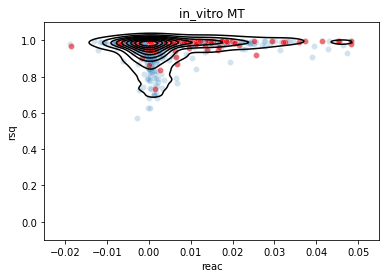

rvalue 0.13977862702310576


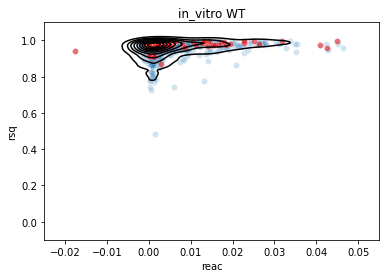

rvalue 0.023914644312664633


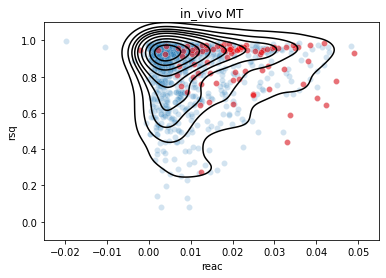

rvalue 0.010455510019439878


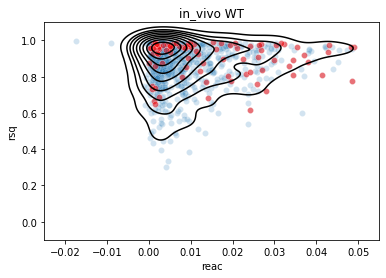

In [215]:
for (transfer, ref), subset in reac2rsq_in_wtmt_df_Separated.groupby(level=['transfer','ref'], axis=1):
    subset.columns = subset.columns.get_level_values('feature')
    riboswitch_subset = subset.loc[subset.index.get_level_values('gene').isin(['Tetrahymena','Den1','HIV'])]
    riboswitch_subset = riboswitch_subset.loc[riboswitch_subset['reac']>-0.02]
    riboswitch_subset = riboswitch_subset.loc[riboswitch_subset['reac']<0.05]
    riboswitch_subset = riboswitch_subset.loc[riboswitch_subset.index.get_level_values('pos')>=30]
    riboswitch_subset = riboswitch_subset.dropna()
    #print (riboswitch_subset)
    
    fig, ax = plt.subplots(1,1)
    sns.scatterplot(data=riboswitch_subset, x="reac", y="rsq", alpha=0.2)
    sns.kdeplot(data=riboswitch_subset, x="reac", y="rsq", color="black")
    
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(riboswitch_subset['reac'], riboswitch_subset['rsq'])
    #print (slope, intercept, rvalue, pvalue, stderr)
    print ("rvalue", rvalue)
    
    #sigdiff_subset = riboswitch_subset.loc[riboswitch_subset.index.isin(structure_diff_regions.index)]
    sigdiff_subset = riboswitch_subset.loc[riboswitch_subset.index.isin(structure_diff_regions_index)]
    sns.scatterplot(data=sigdiff_subset, x="reac", y="rsq", alpha=0.5, color="red")
    
    ax.set_xlim(-0.025, 0.055)
    ax.set_ylim(-0.1, 1.1)
    
    plt.title("{} {}".format(transfer, ref))
    #plt.savefig("reac2rsq_in_Riboswitches/reac2rsq.Separated.{}.{}.pdf".format(transfer, ref))
    plt.show()

In [107]:
#reac2rsq_in_wtmt_df_Mixed = reac2rsq_in_wtmt_df_Mixed.loc[reac2rsq_in_wtmt_df_Mixed.index.get_level_values('gene').isin(['Tetrahymena','Den1','HIV'])]
col_df = reac2rsq_in_wtmt_df_Mixed.columns.to_frame()
col_df.index = list(range(col_df.index.size))
col_df['ref'] = "Mix"
col_df = col_df[['transfer', 'ref', 'feature']]
col_df
local_reac2rsq_in_wtmt_df_Mixed = reac2rsq_in_wtmt_df_Mixed.copy()
local_reac2rsq_in_wtmt_df_Mixed.columns = pd.MultiIndex.from_frame(col_df)
local_reac2rsq_in_wtmt_df_Mixed

transfer          in_vitro   in_vivo  in_vitro   in_vivo
ref                    Mix       Mix       Mix       Mix
feature               reac      reac       rsq       rsq
gene        pos                                         
Den1        1    -0.059480 -0.181894  0.972018  0.920287
            2    -0.045394 -0.059664  0.839778  0.788460
            3     0.004213 -0.008360  0.898981  0.785804
            4    -0.003595  0.016299  0.959773  0.930016
            5     0.031598  0.075706  0.977359  0.902812
...                    ...       ...       ...       ...
human_large 5161       NaN       NaN  0.002800       NaN
            5162       NaN       NaN  0.280059       NaN
            5163       NaN       NaN  0.240785       NaN
            5164       NaN       NaN  0.294378       NaN
            5165       NaN       NaN  0.005657       NaN

[8507 rows x 4 columns]

rvalue -0.45971393848559483
rvalue 0.09521891415750451
rvalue 0.06785870327379417


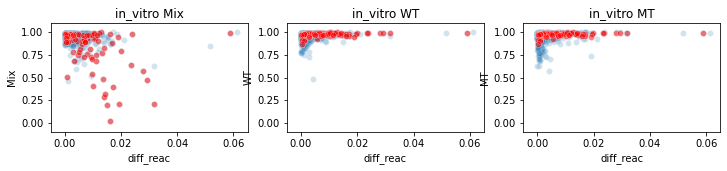

rvalue -0.5072434399247778
rvalue 0.09105884608006072
rvalue 0.05230089819354907


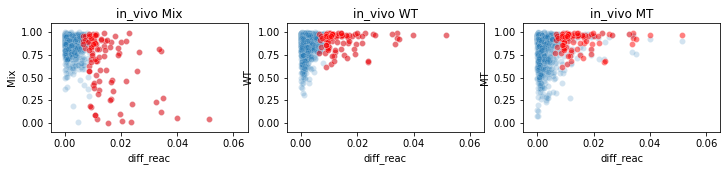

In [211]:
reac2rsq_in_wtmt_df_total = pd.concat([local_reac2rsq_in_wtmt_df_Mixed, reac2rsq_in_wtmt_df_Separated], axis=1)


for transfer, subset in reac2rsq_in_wtmt_df_total.groupby(level="transfer", axis=1):
    subset = subset.droplevel("transfer", axis=1)
    subset_reac = subset.xs('reac', level="feature", axis=1)
    
    subset_reac['diff_reac'] = subset_reac['MT'] - subset_reac['WT']
    subset_rsq = subset.xs('rsq', level="feature", axis=1)
    local_reac2rsq = pd.concat([subset_reac[['diff_reac']], subset_rsq], axis=1)
    local_reac2rsq['diff_reac'] = np.abs(local_reac2rsq['diff_reac'])
    #print (local_reac2rsq)
    
    
    riboswitch_subset = local_reac2rsq.loc[local_reac2rsq.index.get_level_values('gene').isin(['Tetrahymena','Den1','HIV'])]
    #riboswitch_subset = riboswitch_subset.loc[riboswitch_subset['reac']>-0.02]
    #riboswitch_subset = riboswitch_subset.loc[riboswitch_subset['reac']<0.05]
    riboswitch_subset = riboswitch_subset.loc[riboswitch_subset.index.get_level_values('pos')>=30]
    riboswitch_subset = riboswitch_subset.dropna()
    
    fig, axs = plt.subplots(1,3, figsize=(12,2))
    
    ax = axs[0]
    sns.scatterplot(data=riboswitch_subset, x="diff_reac", y="Mix", alpha=0.2, ax=ax)
    #sns.kdeplot(data=riboswitch_subset, x="diff_reac", y="Mix", color="black")
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(riboswitch_subset['diff_reac'], riboswitch_subset['Mix'])
    #print (slope, intercept, rvalue, pvalue, stderr)
    print ("rvalue", rvalue)
    sigdiff_subset = riboswitch_subset.loc[riboswitch_subset.index.isin(structure_diff_regions.index)]
    sns.scatterplot(data=sigdiff_subset, x="diff_reac", y="Mix", alpha=0.5, color="red", ax=ax)
    ax.set_xlim(-0.005, 0.065)
    ax.set_ylim(-0.1, 1.1)
    ax.set_title("{} Mix".format(transfer))
    
    
    
    ax= axs[1]
    sns.scatterplot(data=riboswitch_subset, x="diff_reac", y="WT", alpha=0.2, ax=ax)
    #sns.kdeplot(data=riboswitch_subset, x="diff_reac", y="Mix", color="black")
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(riboswitch_subset['diff_reac'], riboswitch_subset['WT'])
    #print (slope, intercept, rvalue, pvalue, stderr)
    print ("rvalue", rvalue)
    sigdiff_subset = riboswitch_subset.loc[riboswitch_subset.index.isin(structure_diff_regions.index)]
    sns.scatterplot(data=sigdiff_subset, x="diff_reac", y="WT", alpha=0.5, color="red", ax=ax)
    ax.set_xlim(-0.005, 0.065)
    ax.set_ylim(-0.1, 1.1)
    ax.set_title("{} WT".format(transfer))
    
    ax= axs[2]
    sns.scatterplot(data=riboswitch_subset, x="diff_reac", y="MT", alpha=0.2, ax=ax)
    #sns.kdeplot(data=riboswitch_subset, x="diff_reac", y="Mix", color="black")
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(riboswitch_subset['diff_reac'], riboswitch_subset['MT'])
    #print (slope, intercept, rvalue, pvalue, stderr)
    print ("rvalue", rvalue)
    sigdiff_subset = riboswitch_subset.loc[riboswitch_subset.index.isin(structure_diff_regions.index)]
    sns.scatterplot(data=sigdiff_subset, x="diff_reac", y="WT", alpha=0.5, color="red", ax=ax)
    ax.set_xlim(-0.005, 0.065)
    ax.set_ylim(-0.1, 1.1)
    plt.title("{} MT".format(transfer))
    plt.show()